In [17]:
import itertools 
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,SimpleRNN,RNN,Input,Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler

In [19]:
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_squared_error as mse



In [21]:
plt.rcParams.update({'figure.figsize' : (20,10)})

In [23]:
def rmse(x,y):
    return np.round(np.sqrt(mse(x,y)),4)

In [94]:
def create_ds(ds,look_back,look_ahead):
    xdat,ydat = [],[]
    for i in range(len(ds)-look_back-look_ahead):
        xdat.append(ds[i:i+look_back,0])
        ydat.append(ds[i+look_back:i+look_back+look_ahead,0])
    xdat = np.array(xdat)
    ydat = np.array(ydat).reshape(-1,look_ahead)
    return xdat,ydat

# Split the prepped data into training and validation

In [112]:
def data_prep(xdat,ydat,val_cutoff=5000,timesteps=50):
    xtrain= xdat[:val_cutoff,:]
    xval = xdat[val_cutoff:,:]
    ytrain= ydat[:val_cutoff,:]
    yval = ydat[val_cutoff:,:]
    print(xtrain.shape)
    print(xval.shape)
    xtrain = xtrain.reshape(-1,timesteps,1)
    xval = xval.reshape(-1,timesteps,1)

    return xtrain,xval,ytrain,yval

In the 3D LSTM input shape (num_samples, n_steps, n_features), num_samples is the total number of independent sequences (or "windows") you create from your original time series data.

How It’s Calculated:
If your raw data has N time steps, and you use n_steps past values to predict the next step, then:

Copy
num_samples = N - n_steps
Example:

Raw data: 1000 days of stock prices.

You use n_steps = 60 days to predict day 61.

num_samples = 1000 - 60 = 940

In [179]:
df = pd.read_csv("C:/Users/bhara/Downloads/TATASTEEL.csv")
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,TISCO,EQ,142.35,148.00,153.2,146.10,152.50,152.45,150.92,2003185,3.023164e+13,NaN,NaN,NaN
1,2000-01-04,TISCO,EQ,152.45,150.10,153.0,143.05,151.95,150.80,151.03,1555136,2.348785e+13,NaN,NaN,NaN
2,2000-01-05,TISCO,EQ,150.80,144.60,162.9,144.60,158.00,156.55,156.85,3840284,6.023364e+13,NaN,NaN,NaN
3,2000-01-06,TISCO,EQ,156.55,158.95,169.1,158.95,169.00,168.25,167.61,2560449,4.291530e+13,NaN,NaN,NaN
4,2000-01-07,TISCO,EQ,168.25,173.40,179.0,166.30,170.55,171.95,173.89,3641691,6.332459e+13,NaN,NaN,NaN


In [181]:
df=df[["Date","Close"]]

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5306 non-null   object 
 1   Close   5306 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.0+ KB


In [185]:
df["Date"]=pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5306 non-null   datetime64[ns]
 1   Close   5306 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 83.0 KB


In [187]:
df.set_index("Date",inplace=True)

In [189]:
df.head()

,Close
Date,
2000-01-03,152.45
2000-01-04,150.80
2000-01-05,156.55
2000-01-06,168.25
2000-01-07,171.95


<Axes: xlabel='Date'>

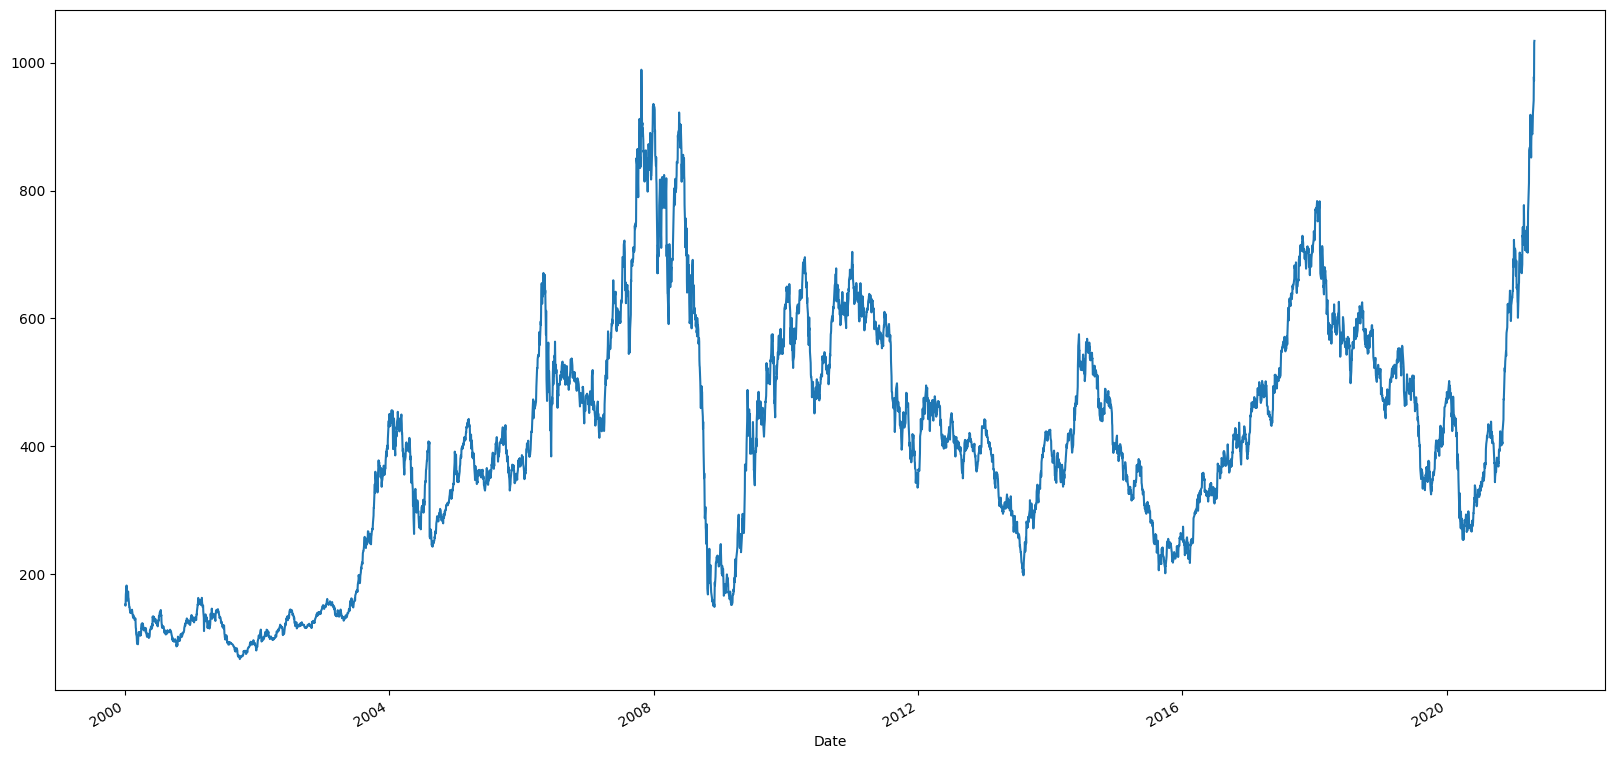

In [191]:
df.Close.plot()

In [192]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)


In [194]:
df

array([[0.08813033],
       [0.08642358],
       [0.09237135],
       ...,
       [0.93524696],
       [0.99725886],
       [1.        ]])

In [197]:
look_back = 60
look_ahead = 1

xdat,ydat = create_ds(df,look_back,look_ahead)


In [199]:
xdat.shape, ydat.shape

((5245, 60), (5245, 1))

In [201]:
xtrain,xval,ytrain,yval=data_prep(xdat,ydat,val_cutoff=5000,timesteps=60)

(5000, 60)
(245, 60)


In [203]:
print("Xtrain Shape")
print(xtrain.shape)
print("Xval Shape")
print(xval.shape)
print("ytrain Shape")
print(ytrain.shape)
print("yval Shape")
print(yval.shape)

Xtrain Shape
(5000, 60, 1)
Xval Shape
(245, 60, 1)
ytrain Shape
(5000, 1)
yval Shape
(245, 1)


## So 245 * 60 gets modified into

### 294 batches 
### 1 batch containing 50 timestamps and 1 feature

In [206]:
model=Sequential()
model.add(SimpleRNN(10,input_shape= [None,1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [208]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

In [210]:
es = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode='min',verbose =1,restore_best_weights = True)

model.fit(x=xtrain,y=ytrain,validation_data=(xval,yval),epochs=50,batch_size=16,callbacks=[es])

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0262 - val_loss: 0.0030
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.7912e-04 - val_loss: 0.0016
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.2575e-04 - val_loss: 9.9194e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.7199e-04 - val_loss: 8.1213e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.9385e-04 - val_loss: 5.7766e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.4479e-04 - val_loss: 5.1529e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.9756e-04 - val_loss: 4.7738e-04
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.7850e-04 - val_loss: 5.6124e-04
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.7327e-04 - val_loss: 4.0195e-04
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.5658e-04 - val_loss: 3.5558e-04
Epoch 10: early stopping
Restoring model weights from the end of the be

In [211]:
y_pred = model.predict(xval)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 


In [212]:
y_pred.shape

(245, 1)

In [213]:
yval.shape

(245, 1)

In [214]:
y_pred1 = scaler.inverse_transform(y_pred)
yval1 = scaler.inverse_transform(yval)

In [220]:
rmse(y_pred1,yval1)

23.2355

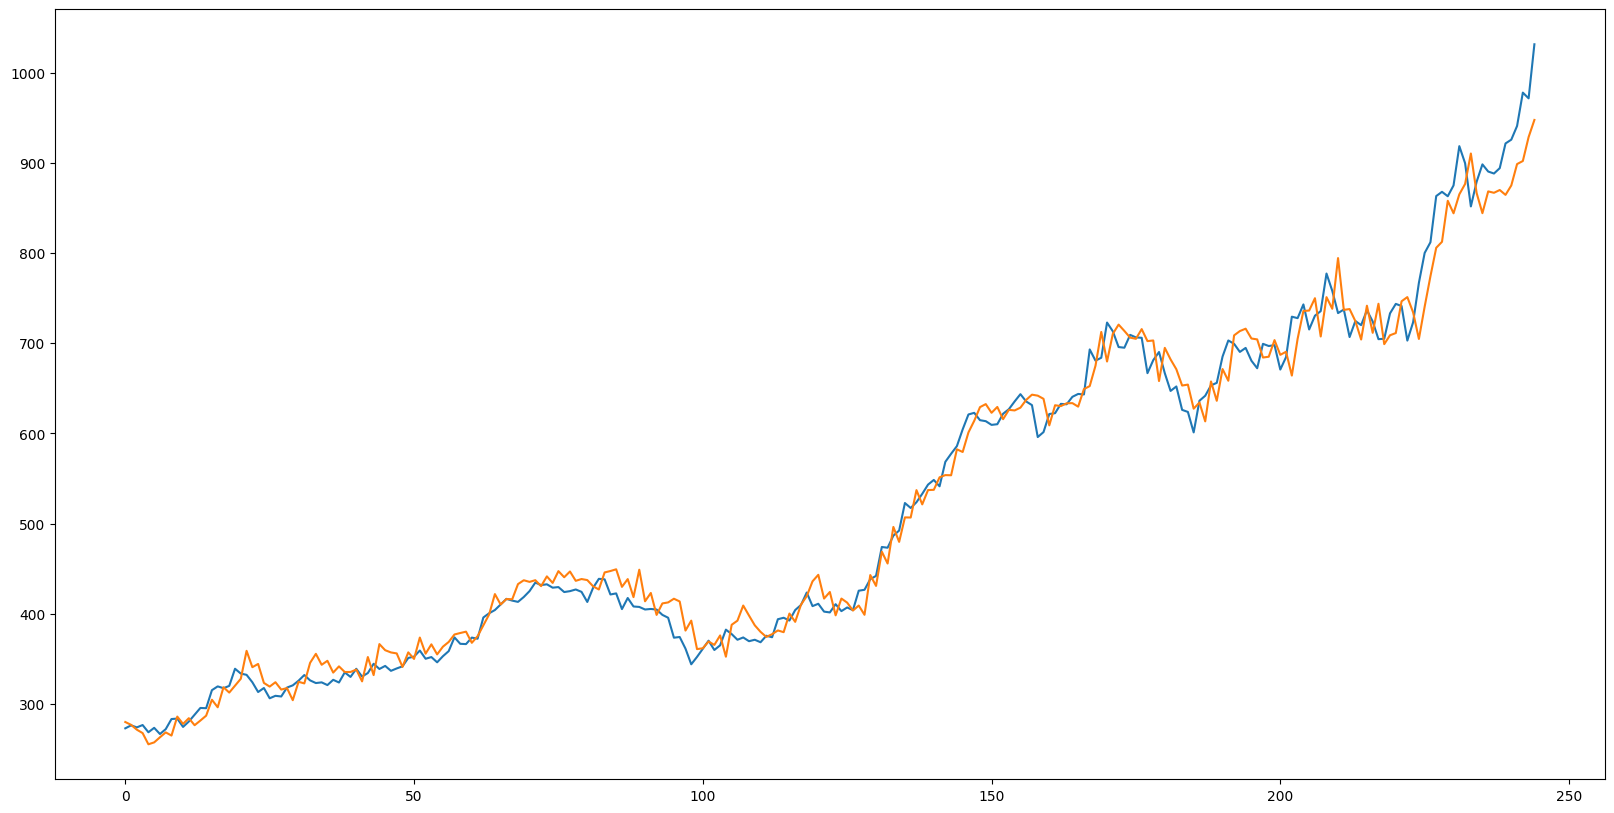

In [224]:
plt.plot(yval1,label="Act")
plt.plot(y_pred1,label="Pred")
plt.show()

# RNN With more layers

In [244]:
look_back = 60
look_ahead = 8
xdat,ydat = create_ds(df,look_back,look_ahead)
xdat.shape, ydat.shape
xtrain,xval,ytrain,yval=data_prep(xdat,ydat,val_cutoff=5000,timesteps=look_back)

model=Sequential()
model.add(SimpleRNN(10,input_shape= [None,1],return_sequences=True))
model.add(SimpleRNN(10,input_shape= [None,1]))
model.add(Dense(look_ahead))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

es = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode='min',verbose =1,restore_best_weights = True)
model.fit(x=xtrain,y=ytrain,validation_data=(xval,yval),epochs=50,batch_size=16,callbacks=[es])

(5000, 60)
(238, 60)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, None, 10)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418 (1.63 KB)

 Trainable params: 418 (1.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1141 - val_loss: 0.0150
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 9.9452e-04 - val_loss: 0.0016
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━

In [246]:
ypreds = model.predict(xval)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step 


In [248]:
ypreds.shape

(238, 8)

In [252]:
ypreds1 = scaler.inverse_transform(ypreds)
yval1 = scaler.inverse_transform(yval)


In [254]:
rmse(ypreds1,yval1)

46.6252

# LSTM With more layers

In [258]:
look_back = 60
look_ahead = 8
xdat,ydat = create_ds(df,look_back,look_ahead)
xdat.shape, ydat.shape
xtrain,xval,ytrain,yval=data_prep(xdat,ydat,val_cutoff=5000,timesteps=look_back)

model1=Sequential()
model1.add(LSTM(10,input_shape= [None,1],return_sequences=True))
model1.add(LSTM(10,input_shape= [None,1]))
model1.add(Dense(look_ahead))

model1.compile(loss='mean_squared_error',optimizer='adam')
model1.summary()

es = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode='min',verbose =1,restore_best_weights = True)
model1.fit(x=xtrain,y=ytrain,validation_data=(xval,yval),epochs=50,batch_size=16,callbacks=[es])

(5000, 60)
(238, 60)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 10)       │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,408 (5.50 KB)

 Trainable params: 1,408 (5.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 0.0404 - val_loss: 0.0044
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [260]:
ypreds = model1.predict(xval)
ypreds1 = scaler.inverse_transform(ypreds)
yval1 = scaler.inverse_transform(yval)
rmse(ypreds1,yval1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 


50.123

## Ventilator Pressure Prediction Dataset

In [265]:
df2 = pd.read_csv("C:/Users/bhara/Downloads/train.csv/train.csv")

In [269]:
df2.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [271]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [277]:
df2.groupby("breath_id")["u_out"].count()

breath_id
1         80
2         80
3         80
4         80
5         80
          ..
125740    80
125742    80
125743    80
125745    80
125749    80
Name: u_out, Length: 75450, dtype: int64